In [1]:
# some standard python imports #
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# import the LensModel class #
from lenstronomy.LensModel.lens_model import LensModel
# import the LightModel class #
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

!dir

 El volumen de la unidad C no tiene etiqueta.
 El n£mero de serie del volumen es: 3288-2E83

 Directorio de C:\Users\Aristizabal.juan\OneDrive - Universidad de Los Andes\H0LICOW\Lenstronomy\Simulaciones\Data R0

09/09/2019  13:03    <DIR>          .
09/09/2019  13:03    <DIR>          ..
30/08/2019  12:00    <DIR>          .ipynb_checkpoints
09/09/2019  08:59    <DIR>          drizzled_image
08/09/2019  10:15          (15.748) Image.png
28/07/2019  17:54            43.200 lens-image.fits
28/12/2017  06:25            43.200 noise_map.fits
28/08/2019  15:14           259.200 oversampled_PSF.fits
28/12/2017  06:25            43.200 psf.fits
30/08/2019  16:26            49.358 Rung000.ipynb
08/09/2019  10:20            64.165 Rung001.ipynb
08/09/2019  10:17          (25.064) Rung002.ipynb
09/09/2019  13:03            48.746 Rung003.ipynb
               9 archivos        591.881 bytes
               4 dirs  122.576.756.736 bytes libres


In [2]:
# Manejo de los  FITS mendiante el HEADER.
import astropy
from astropy.utils.data import download_file
from astropy.io import fits

#fits_image_filename = fits.util.get_testdata_filepath('lens-image.fits')
hdul = fits.open('noise_map.fits')
hdul.info()
image_data = hdul[0].data

print(type(image_data))
print(image_data.shape)

header = hdul['PRIMARY'].header

header

Filename: noise_map.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (99, 99)   float32   
<class 'numpy.ndarray'>
(99, 99)


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   99                                                  
NAXIS2  =                   99                                                  
EXTEND  =                    T                                                  

In [3]:
# Datos observacionales basicos, se recomienda usar los del Hubble 
background_rms = .5  # background noise per pixel
exp_time = 100  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 99  # cutout pixel size
deltaPix = 0.08  # pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF

#Especificaciones del PSF
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 5}
psf_class = PSF(**kwargs_psf)

In [4]:
import lenstronomy.Util.param_util as param_util
#DATOS RUNG-0

#### LENTE SPEMD #####
q = 0.787
phi=1.605
#Transformacion
e1, e2 = param_util.phi_q2_ellipticity(phi=phi, q=q)

#### LENTE LIGHT #####
ql=0.969
phil=1.731
#Transformacion
el1, el2 = param_util.phi_q2_ellipticity(phi=phil, q=ql)

#### SOURCE LIGHT ####
qs = 0.853
phis = 2.805
#Transformacion
es1, es2 = param_util.phi_q2_ellipticity(phi=phis, q=qs)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in log10


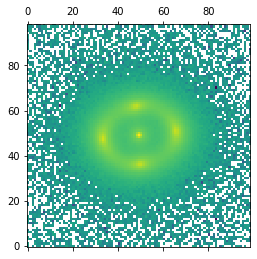

In [5]:
###### LENTE ########

#Modelos de masa y luz para la lente
lens_model_list = ['SPEP', 'SHEAR']
lens_light_model_list = ['SERSIC']

#Modelos de luz de la fuente y el lente
#lightModel_source = LightModel(light_model_list=source_light_model_list)
#lightModel_lens = LightModel(light_model_list=lens_light_model_list)

lensModel = LensModel(lens_model_list=lens_model_list)

#Modelos de distribucion de masa del lente
#kwargs_shear = {'gamma_ext': 0.01, 'psi_ext': -0.1} #parametros sin fundamento
kwargs_shear = {'e1': 0.007, 'e2': 0.027} # de acuerdo al Rung0
kwargs_spemd = {'theta_E':1.161,'gamma':2.044,'center_x':0,'center_y':0,'e1':e1,'e2':e2}
kwargs_lens = [kwargs_spemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

#Definiendo modelos de luz SERSIC del lente
kwargs_sersic = {'amp': 400, 'R_sersic': 0.991, 'n_sersic': 3.786, 'center_x': 0, 'center_y': 0}
kwargs_lens_light = [kwargs_sersic]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)



###### FUENTE #######

source_model_list = ['SERSIC_ELLIPSE']

# Modelos de luz para la fuente
ra_source, dec_source = 0.02, 0.001
kwargs_sersic_ellipse = {'amp':4000,'R_sersic':0.338,'n_sersic':2.582,'center_x':ra_source, 'center_y':dec_source, 'e1':es1, 'e2':es2} 
kwargs_source = [kwargs_sersic_ellipse]
source_model_class = LightModel(light_model_list=source_model_list)


##### SOLUCION DE LENTE ########
lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(ra_source, dec_source, kwargs_lens, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': np.abs(mag)*100}]  # quasar point source position in the source plane and intrinsic brightness
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                lens_light_model_class,
                                point_source_class, kwargs_numerics=kwargs_numerics)
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
image_sim = image_sim + bkg + poisson

kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)

plt.matshow(np.log10(image_sim), origin='lower')
plt.show()
